In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from flim.experiments import utils, LIDSDataset, ToTensor
from flim.models.lcn import LCNCreator
import torch
from torch import Tensor
from torch import nn
from torch.nn import functional as F
from torch import optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchsummary import summary
import torchmetrics as tm
from torch_snippets import *
from math import ceil, floor
import copy
import os
from os import path
import numpy as np
from medpy.metric import binary
print(torch.__version__)
print(torch.cuda.device_count())

1.11.0
1


***
## Overview
This is a demo jupyter notebook that takes a pretrained FLIM encoder and docks it with a U-Net decoder for image segmentation.

In [2]:
if torch.cuda.is_available():
    device = torch.device(0)
else:
    device = 'cpu'

***
## DataLoader

In [3]:
class ToTensor(object):
    def __call__(self, image):
        return torch.from_numpy(image.copy()).float()

class SegmDataset():
    def __init__(self, input_dir,  gt_dir, ext='.nii.gz'):
        assert isinstance(input_dir, str) and len(input_dir) > 0,\
            "Invalid input_dir"
            
        assert isinstance(gt_dir, str) and len(gt_dir) > 0,\
            "Invalid gt_dir"

        self.gt_dir          = gt_dir
        self.input_dir       = input_dir
        self.ext             = ext 
        self.transform       = ToTensor()
        self.image_basenames = None
        self.gt_basenames    = None
        self.image_names     = None
        self.gt_names        = None
        self.get_image_basenames()
        self.get_gt_basenames()

    def __getitem__(self, index):

        self.image_basenames = self.get_image_basenames()
        self.gt_basenames    = self.get_gt_basenames()
        
        image_path = os.path.join(self.input_dir, self.image_basenames[index]+self.ext)
        image      = utils.load_image(image_path)
        image      = self.transform(image).permute(3,0,1,2)
    
        gt_path = os.path.join(self.gt_dir, self.gt_basenames[index]+self.ext)
        gt      = utils.load_image(gt_path, lab=False)
        gt      = self.transform(gt).permute(0,1,2)
    
        return image, gt 
    
    def __len__(self):
        return len(self.image_names)

    def get_image_basenames(self):
     
        if path.exists(self.input_dir):
            self.image_names = []
            for name in os.listdir(self.input_dir):
                if name.endswith(self.ext):
                    self.image_names.append(name.split(self.ext)[0])
                else:
                    continue
            self.image_names.sort()
        else:
            print("{} does not exist".format(self.input_dir))
            exit()
 
        return(self.image_names)
    
    def get_gt_basenames(self):
     
        if path.exists(self.gt_dir):
            self.gt_names = []
            for name in os.listdir(self.gt_dir):
                if name.endswith(self.ext):
                    self.gt_names.append(name.split(self.ext)[0])
                else:
                    continue
            self.gt_names.sort()
        else:
            print("{} does not exist".format(self.gt_dir))
            exit()
               
        return(self.gt_names)

***
## Setting up experiment
Setting image sizes and channels

In [4]:
ncols = 120
nrows = 160
depth = 200
bands = 3

torch.manual_seed(42)

Creating output folder. Please, assign the respective output dir

In [5]:
output_dir = "output" # output model dir
if (not os.path.exists(output_dir)):
    os.makedirs(output_dir)
print(output_dir)

output


Loading training and validation images. Please, assign the training and validation/testing paths accordingly

In [6]:
train_path = "train" #path to training images
train_gt_path = "train_gt" #path to training ground truth

test_path = "test" #path to validation/testing images
test_gt_path = "test_gt" #path to validation/testing ground truth

train_ds = SegmDataset(train_path, 
                       train_gt_path)
                       
test_ds  = SegmDataset(test_path, 
                       test_gt_path)

"""
Important, in case you are using the DeepLabV3 decoder model, the batch size 
must not leave a batch with a single image, otherwise it will raise an error 
when running the BatchNorm3D.
"""
train_dl = DataLoader(train_ds, batch_size=3, num_workers=0, shuffle=True)
test_dl  = DataLoader(test_ds, batch_size=1, num_workers=0, shuffle=True)

***
## Training FLIM network
Please, provide the path containing the FLIM model training with the libift and the name of the architecture. Note that the architecture is searched inside the model's path.

In [7]:
model_path        = "./model"# path to the model trained with FLIM.
architecture_name = "arch3D-python.json"# name of the architecture to be searched in the model_path 
print(model_path)
architecture    = utils.load_architecture('%s/%s' % (model_path,architecture_name))

encoder         = utils.build_model(architecture, input_shape=[3]).features
encoder         = utils.load_weights_from_lids_model(encoder, '%s/' % (model_path)).to(device=device)

./model
Loading LIDS model...
block1.m-norm1
block1.conv1
block1.relu1
block1.pool1
block2.m-norm2
block2.conv2
block2.relu2
block2.pool2
Finish loading...


In [8]:
print(encoder)
summary(encoder, (bands, depth, nrows, ncols))

Sequential(
  (block1): Sequential(
    (m-norm1): MarkerBasedNorm3d(3, epsilon=0.001)
    (conv1): Conv3d(3, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (relu1): ReLU(inplace=True)
    (pool1): MaxPool3d(kernel_size=[3, 3, 3], stride=2, padding=[1, 1, 1], dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (m-norm2): MarkerBasedNorm3d(32, epsilon=0.001)
    (conv2): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (relu2): ReLU(inplace=True)
    (pool2): MaxPool3d(kernel_size=[3, 3, 3], stride=2, padding=[1, 1, 1], dilation=1, ceil_mode=False)
  )
)
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 32, 100, 80, 60]     --
|    └─MarkerBasedNorm3d: 2-1            [-1, 3, 200, 160, 120]    12
|    └─Conv3d: 2-2                       [-1, 32, 200, 160, 120]   2,592
|    └─ReLU: 2-3                         [-1, 32, 200, 160, 120]   -

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 32, 100, 80, 60]     --
|    └─MarkerBasedNorm3d: 2-1            [-1, 3, 200, 160, 120]    12
|    └─Conv3d: 2-2                       [-1, 32, 200, 160, 120]   2,592
|    └─ReLU: 2-3                         [-1, 32, 200, 160, 120]   --
|    └─MaxPool3d: 2-4                    [-1, 32, 100, 80, 60]     --
├─Sequential: 1-2                        [-1, 64, 50, 40, 30]      --
|    └─MarkerBasedNorm3d: 2-5            [-1, 32, 100, 80, 60]     128
|    └─Conv3d: 2-6                       [-1, 64, 100, 80, 60]     55,296
|    └─ReLU: 2-7                         [-1, 64, 100, 80, 60]     --
|    └─MaxPool3d: 2-8                    [-1, 64, 50, 40, 30]      --
Total params: 58,028
Trainable params: 58,028
Non-trainable params: 0
Total mult-adds (G): 36.50
Input size (MB): 43.95
Forward/backward pass size (MB): 1376.95
Params size (MB): 0.22
Estimated Total Size (MB): 1421.1

***
## Preparing FLIM U-NET
Here, the U-Net is built according to the FLIM encoder.

In [9]:
def conv(in_channels, out_channels, padding=1):
    return nn.Sequential(
        nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=1, padding=padding),
        nn.BatchNorm3d(out_channels),
        nn.ReLU(inplace=True),
        #nn.BatchNorm3d(out_channels)
    )

All weights are initialized from with the xavier uniform distribution algorithm.

In [10]:
def init_weights(m):
    if (isinstance(m,nn.Conv3d) or (isinstance(m,nn.ConvTranspose3d))):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)

In [11]:
class interp_up_conv(nn.Module):
    def __init__(self,in_channels, out_channels, kernel_size=3, stride=1, padding=1,new_dim=(100,200,300)):
        super().__init__()

        self.new_D      = new_dim[0]
        self.new_H      = new_dim[1]
        self.new_W      = new_dim[2]
        self.conv       = nn.Conv3d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.batch_norm = nn.BatchNorm3d(out_channels)
        self.relu       = nn.ReLU(inplace=True)
        self.conv.apply(init_weights)

    def forward(self,x):

        x = F.interpolate(x,(self.new_D,self.new_H,self.new_W),mode="trilinear")
        x = self.conv(x)
        x = self.batch_norm(x)
        x = self.relu(x)

        return x


def up_conv(in_channels, out_channels, kernel_size=2, padding=0, stride=2, output_padding=(0,0,0)):
    return nn.Sequential(
        nn.ConvTranspose3d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=stride, output_padding=output_padding),
        nn.ReLU(inplace=True)
    )

Now, the class that defines the UNet decoder.

In [12]:
class UNetOneLayer(nn.Module):
    def __init__(self, in_channels=3, out1_channels=32, out_channels=2):
        super().__init__()
        
        self.block1     = encoder.block1 # in: 3  out: 32
        self.bottleneck = nn.Conv3d(out1_channels, 2*out1_channels, kernel_size=3, stride=2, padding=(1,1,1))
        self.up_conv1   = up_conv(2*out1_channels,out1_channels) 
        self.conv1      = conv(out1_channels+out1_channels,out1_channels)
        self.up_conv2   = up_conv(out1_channels,out1_channels) 
        self.pred       = nn.Conv3d(out1_channels, out_channels, kernel_size=1)    

        # Initilizing weights
        self.bottleneck.apply(init_weights)
        self.up_conv1.apply(init_weights)
        self.conv1.apply(init_weights)
        self.up_conv2.apply(init_weights)
        self.pred.apply(init_weights)
        
    def forward(self, x):
        shape = x.shape
        input = x
        
        x1     = self.block1(x)
        bottleneck = self.bottleneck(x1)
        x      = self.up_conv1(bottleneck)
        x      = torch.cat([x, x1], dim=1)
        x      = self.conv1(x)
        x      = self.up_conv2(x)
        x      = self.pred(x)         
    
        return x

class UNetTwoLayers(nn.Module):
    def __init__(self, in_channels=3, out1_channels=32, out2_channels=64, out_channels=2):
        super().__init__()
        
        self.block1     = encoder.block1 # in: 3  out: 32
        self.block2     = encoder.block2 # in: 32 out: 64     
        self.bottleneck = nn.Conv3d(out2_channels, 2*out2_channels, kernel_size=3, stride=2, padding=(1,1,1))
        self.up_conv1   = up_conv(2*out2_channels,out2_channels) 
        self.conv1      = conv(out2_channels+out2_channels,out2_channels)
        self.up_conv2   = up_conv(out2_channels,out1_channels) 
        self.conv2      = conv(out1_channels+out1_channels,out1_channels) 
        self.up_conv3   = up_conv(out1_channels,out1_channels)
        self.pred       = nn.Conv3d(out1_channels, out_channels, kernel_size=1)    

        # Initilizing weights
        self.bottleneck.apply(init_weights)
        self.up_conv1.apply(init_weights)
        self.conv1.apply(init_weights)
        self.up_conv2.apply(init_weights)
        self.conv2.apply(init_weights)
        self.up_conv3.apply(init_weights)
        self.pred.apply(init_weights)
        
    def forward(self, x):
        shape = x.shape
        input = x
        
        x1     = self.block1(x)
        x2     = self.block2(x1)        
        bottleneck = self.bottleneck(x2)
        x      = self.up_conv1(bottleneck)
        x      = torch.cat([x, x2], dim=1)
        x      = self.conv1(x)
        x      = self.up_conv2(x)
        x      = torch.cat([x, x1], dim=1)
        x      = self.conv2(x)
        x      = self.up_conv3(x) 
        x      = self.pred(x)         
    
        return x

In [13]:
in_channels   = 3
out1_channels = 32
out2_channels = 64
model = UNetTwoLayers(in_channels,out1_channels,out2_channels).to(device)
#model = UNetOneLayer(in_channels,out1_channels).to(device)

### Freezing layers
Uncomment the blocks to freeze specific layers

In [14]:
# Freezing encoder layers
for param in model.block1.parameters():
    param.requires_grad = False
for param in model.block2.parameters():
    param.requires_grad = False

### Printing module

In [15]:
print(model)
summary(model, (bands, depth, nrows, ncols))

from contextlib import redirect_stdout

with open(output_dir+'/model_summary.txt', 'w') as f:
    with redirect_stdout(f):
        summary(model, (bands, depth, nrows, ncols))

UNetOneLayer(
  (block1): Sequential(
    (m-norm1): MarkerBasedNorm3d(3, epsilon=0.001)
    (conv1): Conv3d(3, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (relu1): ReLU(inplace=True)
    (pool1): MaxPool3d(kernel_size=[3, 3, 3], stride=2, padding=[1, 1, 1], dilation=1, ceil_mode=False)
  )
  (bottleneck): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
  (up_conv1): Sequential(
    (0): ConvTranspose3d(64, 32, kernel_size=(2, 2, 2), stride=(2, 2, 2))
    (1): ReLU(inplace=True)
  )
  (conv1): Sequential(
    (0): Conv3d(64, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (up_conv2): Sequential(
    (0): ConvTranspose3d(32, 32, kernel_size=(2, 2, 2), stride=(2, 2, 2))
    (1): ReLU(inplace=True)
  )
  (pred): Conv3d(32, 2, kernel_size=(1, 1, 1), stride=(1, 1, 1))
)
Layer (type:depth-idx)

***
# Training FLIM U-NET

Here is the definition of the our loss. The proposed loss for segmentation is the weighted CE + DICE loss. The original CE loss is susceptible to unbalanced data, and our images have small objects, therefore, we gave low weights (0.1) for the background and a high weight (0.9) to the object. If your case differs from the one just depicted, please fit the weights according to your problem.

In [16]:
def BinaryDice(prediction, targets):
    targets    = targets != 0
    prediction = prediction.cpu()
    targets    = targets.cpu()
    score      = []
    for p, t in zip(prediction, targets):
        score.append(binary.dc(p.numpy(), t.numpy()))
    return torch.tensor(score).mean()

def DiceLoss(prediction, targets, smooth=1):
    inputs = torch.softmax(prediction, dim=1) # can be softmax or sigmoid
    inputs = inputs[:,1,:,:,:]
    inputs = inputs.contiguous().view(-1)
    targets = targets.contiguous().view(-1)
    intersection = (inputs * targets).sum()
    dice_loss = 1 - (2 * intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
    return dice_loss

def UnetLoss(preds, targets):
    weights       = [0.1,0.9] # best -> [0.1, 0.9]
    class_weights = torch.FloatTensor(weights).to(device)
    ce            = nn.CrossEntropyLoss(weight=class_weights).to(device)

    pred_labels = torch.max(preds, 1)[1] # same as argmax
    dice_loss   = DiceLoss(preds, targets.long())
    dice        = BinaryDice(targets.long(),pred_labels)
    ce_loss     = ce(preds, targets.long())
    loss        = ce_loss + dice_loss
    return loss, dice

In [17]:
def train_batch(model, data, optimizer, criterion, device):
    model.train()
    ims, masks = data
    ims   = ims.to(device=device)
    masks = masks.to(device=device)
    _masks = model(ims)
    loss, dice = criterion(_masks, masks)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss.item(), dice.item()

@torch.no_grad()
def validate_batch(model, data, criterion, device):
    model.eval()
    ims, masks = data
    ims   = ims.to(device=device)
    masks = masks.to(device=device)
    _masks = model(ims)
    loss, dice = criterion(_masks, masks)
    return loss.item(), dice.item()

In [18]:
criterion = UnetLoss
learning_rate = 1e-2
optimizer = optim.Adam(model.parameters(), lr=learning_rate,  weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
n_epochs  = 150

In [19]:
# initializing variables
log = Report(n_epochs)
current_lr = learning_rate
final_val_dice = 0

# starting training
for ex in range(n_epochs):
    N = len(train_dl)
    for bx, data in enumerate(train_dl):
        loss, dice = train_batch(model, data, optimizer, criterion, device)
        log.record((ex+(bx+1)/N), trn_loss=loss, trn_dice=dice, end='\r')

    N = len(test_dl)
    for bx, data in enumerate(test_dl):
        loss, dice = validate_batch(model, data, criterion, device)
        final_val_dice = dice
        log.record((ex+(bx+1)/N), val_loss=loss, val_dice=dice, end='\r')

    log.report_avgs(ex+1)
    scheduler.step()
    if scheduler.get_last_lr()[0] < current_lr:
        current_lr = scheduler.get_last_lr()[0]
        print("updating learning rate: "+str(current_lr))

EPOCH: 1.000	trn_loss: 1.466	trn_dice: 0.222	val_loss: 0.928	val_dice: 0.259	(7.36s - 1096.02s remaining)
EPOCH: 2.000	trn_loss: 0.875	trn_dice: 0.626	val_loss: 0.776	val_dice: 0.435	(14.61s - 1081.11s remaining)
EPOCH: 3.000	trn_loss: 0.475	trn_dice: 0.670	val_loss: 0.503	val_dice: 0.702	(21.94s - 1075.24s remaining)
EPOCH: 4.000	trn_loss: 0.486	trn_dice: 0.697	val_loss: 0.286	val_dice: 0.795	(29.26s - 1068.00s remaining)
EPOCH: 5.000	trn_loss: 0.442	trn_dice: 0.688	val_loss: 0.436	val_dice: 0.750	(36.51s - 1058.84s remaining)
EPOCH: 6.000	trn_loss: 0.378	trn_dice: 0.757	val_loss: 0.341	val_dice: 0.789	(43.81s - 1051.47s remaining)
EPOCH: 7.000	trn_loss: 0.390	trn_dice: 0.743	val_loss: 0.332	val_dice: 0.752	(51.10s - 1043.95s remaining)
EPOCH: 8.000	trn_loss: 0.341	trn_dice: 0.783	val_loss: 0.289	val_dice: 0.777	(58.30s - 1034.89s remaining)
EPOCH: 9.000	trn_loss: 0.481	trn_dice: 0.645	val_loss: 0.343	val_dice: 0.717	(65.60s - 1027.71s remaining)
EPOCH: 10.000	trn_loss: 0.387	trn_dice

100%|███████████████████████████████████████| 251/251 [00:00<00:00, 8920.50it/s]


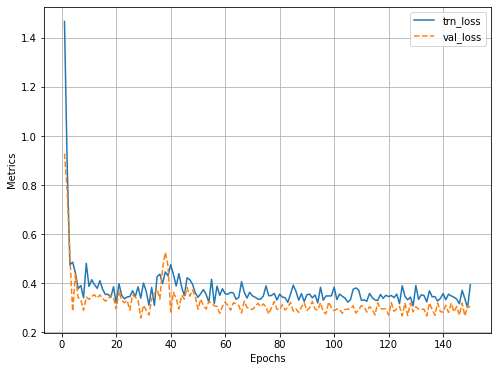

In [20]:
log.plot_epochs(['trn_loss','val_loss'])

100%|███████████████████████████████████████| 251/251 [00:00<00:00, 3215.26it/s]


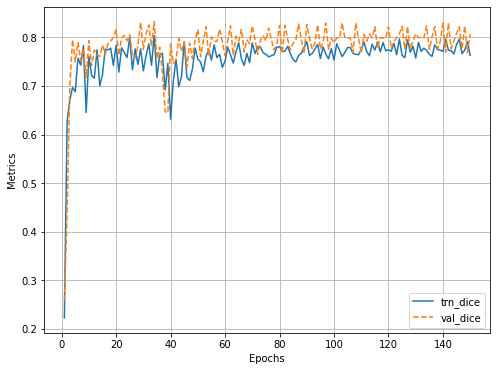

In [21]:
log.plot_epochs(['trn_dice','val_dice'])

***
## Saving model

In [22]:
# Creating output model dir
model_name       = "flim_unet_epoch%d_valdice%f" % (n_epochs,final_val_dice)
output_model_dir = output_dir + "/output_model/"
if not(os.path.exists(output_model_dir)):
    os.makedirs(output_model_dir)

# Saving output model in LIDS format
utils.save_lids_model(encoder,architecture,output_model_dir,"trained_flim_model/")

# Saving output model in Torch format
torch.save(model,output_model_dir+model_name+".pt")

Saving model in LIDS format...


***
## Writting predicted segmentation

In [23]:
import nibabel as nib

def save_pred(output_dir, pred, basename):
    
    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)
    pred    = torch.max(pred, 1)[1]
    outdata = pred.squeeze(0).detach().cpu().numpy().astype(np.int8).transpose(2,1,0)
    outimg  = nib.Nifti1Image(outdata, affine=np.eye(4)*[-1,-1,1,1])
    outname = os.path.join(output_dir, basename + '.nii.gz')
    nib.save(outimg, outname)

basenames = train_ds.image_basenames
for i in range(len(basenames)):    
    ims, _ = train_ds[i]
    ims    = ims.unsqueeze(0)
    ims    = ims.to(device=device)
    pred   = model(ims)
    save_pred(output_dir+"/train_output",pred,basenames[i])

basenames = test_ds.image_basenames
for i in range(len(basenames)):    
    ims, _ = test_ds[i]
    ims    = ims.unsqueeze(0)
    ims    = ims.to(device=device)
    pred   = model(ims)
    save_pred(output_dir+"/test_output",pred,basenames[i])

***
## Writting training log

In [24]:
import contextlib
with open(output_dir+'/Log.txt','w') as f:
    with contextlib.redirect_stdout(f):
        for i in range(1,n_epochs+1):
            log.report_avgs(i)